In [49]:
%%capture
!pip install atomate2[strict]

In [50]:
import warnings
warnings.filterwarnings('ignore')

First we load makers from atomate2. Makers can be used to generate Flow objects with default values in a convenient way.

In [51]:
#from atomate2.vasp.jobs.core import RelaxMaker, StaticMaker, RelaxSetGenerator
from atomate2.forcefields.jobs import CHGNetRelaxMaker, CHGNetStaticMaker, M3GNetRelaxMaker, M3GNetStaticMaker, GAPRelaxMaker, GAPStaticMaker


Then, we need standard classes, decorators, functions from jobflow

In [52]:
from jobflow import job, Response, Flow, run_locally, Maker
from dataclasses import dataclass

We define a job to create a flow including constant volume optimizations

In [53]:
@job
def get_energies(structure, volume_increments=[0.95,0.97,0.99, 1.00, 1.01, 1.03, 1.05 ]):
    jobs=[]
    volumes=[]
    energies=[]
    for inc in volume_increments:
        new_structure=structure.copy()
        new_structure.scale_lattice(structure.volume*inc)
        # job=RelaxMaker(input_set_generator=RelaxSetGenerator(user_incar_settings={"ISIF": 4})).make(new_structure)
        new_job=M3GNetRelaxMaker(relax_cell=False, relax_kwargs={"fmax": 0.0001}).make(new_structure)
        jobs.append(new_job)
        volumes.append(new_job.output.structure.volume)
        energies.append(new_job.output.output.energy)
    return Response(replace=Flow(jobs, output={"energies": energies, "volumes": volumes}))


We then compute the ev curve in a job starting from a list of energies, volumes

In [54]:
from ase.units import kJ
from ase.eos import EquationOfState

@job
def get_results_ev_curve(list_volumes, list_energies):
    eos = EquationOfState(list_volumes, list_energies)
    v0, e0, B = eos.fit()
    eos.plot('eos.png')

    results = {}
    results["V0"] = v0
    results["e0"] = e0
    results["B"] = B

    return results

We define a Maker for convenience

In [55]:
@dataclass
class EVMaker(Maker):
    name="ev"
    def make(self, structure):

        job1=M3GNetRelaxMaker(relax_cell=True, relax_kwargs={"fmax": 0.0001}).make(structure=structure)
        job2=get_energies(job1.output.structure)
        job3=get_results_ev_curve(list_volumes=job2.output["volumes"], list_energies=job2.output["energies"])
        return Flow([job1,job2,job3], job3.output)

Start the workflow

In [56]:
from pymatgen.core import Structure
structure = Structure(
    lattice=[[0, 2.73, 2.73], [2.73, 0, 2.73], [2.73, 2.73, 0]],
    species=["Si", "Si"],
    coords=[[0, 0, 0], [0.25, 0.25, 0.25]],
)
print(structure.volume)
flow=EVMaker().make(structure=structure)

40.692834


Then, we run it.

2023-10-31 17:44:06,735 INFO Started executing jobs locally
2023-10-31 17:44:06,739 INFO Starting job - M3GNet relax (af81b0e7-7f82-4437-b290-638de98124c8)
2023-10-31 17:44:10,831 INFO Finished job - M3GNet relax (af81b0e7-7f82-4437-b290-638de98124c8)
2023-10-31 17:44:10,837 INFO Starting job - get_energies (aa500484-b2f7-4d30-8823-be55abe104f0)
2023-10-31 17:44:11,039 INFO Finished job - get_energies (aa500484-b2f7-4d30-8823-be55abe104f0)
2023-10-31 17:44:11,048 INFO Starting job - M3GNet relax (1e4dbfd0-a9c5-4563-a519-4f30bff6fd38)
2023-10-31 17:44:11,395 INFO Finished job - M3GNet relax (1e4dbfd0-a9c5-4563-a519-4f30bff6fd38)
2023-10-31 17:44:11,397 INFO Starting job - M3GNet relax (cac4d8aa-1bd6-4604-8a08-cab4d96d2e7d)
2023-10-31 17:44:11,734 INFO Finished job - M3GNet relax (cac4d8aa-1bd6-4604-8a08-cab4d96d2e7d)
2023-10-31 17:44:11,738 INFO Starting job - M3GNet relax (4744ce86-a252-4b29-9f16-534c105eb05c)
2023-10-31 17:44:12,080 INFO Finished job - M3GNet relax (4744ce86-a252-4b29

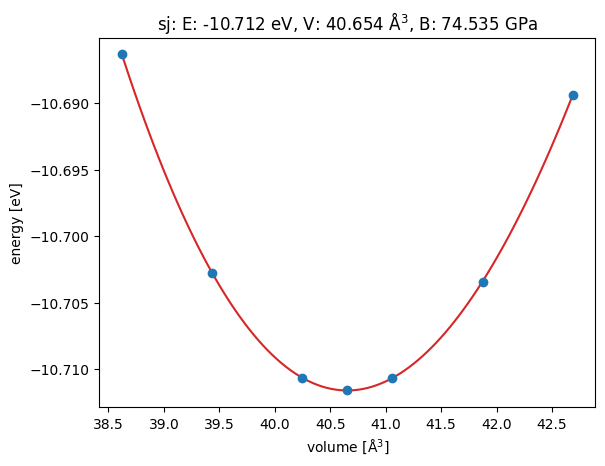

In [57]:
response=run_locally(flow)

In [58]:
print(response[flow[2].uuid][1].output)

{'V0': 40.65357432923033, 'e0': -10.711596589376484, 'B': 0.4652098738365982}
